# Nonlinear PDE: 2D semilinear elliptic equations 

Our goal is to solve the following nonlinear PDE:

$$ - \Delta u(x) + u(x)^3 = f(x), \quad x \in \Omega $$
$$ u(x) = g(x), \quad x\in\partial\Omega$$


In [2]:
import torch 
import torch.nn as nn 
from collections import OrderedDict 

import numpy as np 
import matplotlib.pyplot as plt
import scipy.io 
from scipy.interpolate import griddata 

from mpl_toolkits.axes_grid1 import make_axes_locatable 
import matplotlib.gridspec as gridspec 
import warnings 

warnings.filterwarnings('ignore') 

np.random.seed(1234) 


In [3]:
# MPS or CUDA or CPU 
if torch.backends.mps.is_available():
    device = torch.device('mps') 
elif torch.cuda.is_available():
    device = torch.device('cuda') 
else:
    device = torch.device('cpu') 
# 
print(f"Working on {device}") 


Working on mps


<span style="font-size:20pt"> Building the PINN </span>

In [4]:
# The deep neural network 
class DNN(nn.Module):
    def __init__(self, layers): 
        super(DNN, self).__init__() 

        # parameters 
        self.depth = len(layers) - 1 

        # set up layer order dict 
        self.activation = nn.Tanh 

        layer_list = list() 
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, nn.Linear(layers[i], layers[i+1])) 
            ) 
            layer_list.append(('activation_%d' % i, self.activation()))

        layer_list.append(
            ('layer_%d' % (self.depth - 1), nn.Linear(layers[-2], layers[-1]))
        ) 
        layerDict = OrderedDict(layer_list)
        
        # deploy layers 
        self.layers = nn.Sequential(layerDict) 

    def forward(self, x): 
        out = self.layers(x) 

        return out 

    
        

In [5]:
class PINN(): 
    def __init__(self, X, u, layers, bc_h, bc_v, lb, ub, g1, g2, g3, g4): # , force_func): # X, u: training data for the interior points; 
        # gi, i = 1,2,3,4 mean boundary conditions; bc_h: left and right boundary points; bc_v: bottom and top boundary points 

        # boundary conditions: domain bounds 
        self.lb = torch.tensor(lb).float().to(device) 
        self.ub = torch.tensor(ub).float().to(device) 

        # data 
        self.x = torch.tensor(X[:, 0:1], requires_grad = True).float().to(device) # x-axis 

        self.y = torch.tensor(X[:, 1:2], requires_grad = True).float().to(device) # y-axis 

        self.u = torch.tensor(u).float().to(device) # training solutions values: initial and boundary conditions 

        # boundary data 
        self.y_lb = torch.tensor(bc_h[:, 0:1], requires_grad = True).float().to(device) # left boundary points 
        self.y_rb = torch.tensor(bc_h[:, 1:2], requires_grad = True).float().to(device) # right boundary points 
        self.x_bb = torch.tensor(bc_v[:, 0:1], requires_grad = True).float().to(device) # bottom boundary points 
        self.x_tb = torch.tensor(bc_v[:, 1:2], requires_grad = True).float().to(device) # top boundary points 
        
        # No need to learn any parameters in this semilinear equations 
        # deep neural networks     
        self.dnn = DNN(layers).to(device) 
        

        # optimizers: 
        self.optimizer = torch.optim.LBFGS( # require multiple evaluations of the loss function per iteraton
            self.dnn.parameters(), # target to be optimized 
            lr = 1.0, # learning rate: step length 
            max_iter = 50000, # maximum number of iterations: can be reduced 
            max_eval = 50000, # total numebr of times the closure ( loss + backward pass) can be called
            history_size = 50, 
            tolerance_grad = 1e-5, 
            tolerance_change = 1.0 * np.finfo(float).eps,
            line_search_fn = "strong_wolfe" 
        ) 

        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters()) # Check learning rate for Adam 
    
        self.iter = 0 
        
    def force_func(self, x, y): 

        return 2 * torch.pi ** 2 * torch.sin(torch.pi * x) * torch.sin(torch.pi * y) + torch.pow(torch.sin(torch.pi * x) * torch.sin(torch.pi * y), 3.0)  
    
    def net_u(self, x, y): # predicted value 
        u = self.dnn(torch.cat([x,y], dim = 1)) 
        return u 

    def net_f(self, x, y): 
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x, y) 
        
        force = self.force_func(x, y) # force term values at these points (x,y)  
        
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs = torch.ones_like(u), 
            retain_graph = True, 
            create_graph = True
        )[0]

        u_y = torch.autograd.grad(
            u, y, 
            grad_outputs = torch.ones_like(u), 
            retain_graph = True, 
            create_graph = True 
        )[0] 

        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs = torch.ones_like(u_x),
            retain_graph = True,
            create_graph = True 
        )[0] 

        u_yy = torch.autograd.grad(
            u_y, y, 
            grad_outputs = torch.ones_like(u_y), 
            retain_graph = True, 
            create_graph = True
        )[0] 
        # PDE residual loss 
        f =  - u_xx - u_yy + u ** 3 - force 
        return f 
        
    # Boundary condition loss 
    def bc_loss_func(self, x_bb, x_tb, y_lb, y_rb):

        x_lb = self.lb[0] * torch.ones_like(y_lb)
        x_rb = self.ub[0] * torch.ones_like(y_rb) 
        y_bb = self.lb[1] * torch.ones_like(x_bb) 
        y_tb = self.ub[1] * torch.ones_like(x_tb) 
        u_lb = self.net_u(x_lb, y_lb) # left boundary  
        u_rb = self.net_u(x_rb, y_rb) # right boundary 
        u_bb = self.net_u(x_bb, y_bb) # bottom boundary 
        u_tb = self.net_u(x_tb, y_tb) # top boundary 

        bc_loss = torch.mean(u_lb ** 2) + torch.mean(u_rb ** 2) + torch.mean(u_bb ** 2) + torch.mean(u_tb ** 2) 
        return bc_loss 

    def loss_func(self): 
        
        f_pred = self.net_f(self.x, self.y) 
        loss = torch.mean(f_pred ** 2) + self.bc_loss_func(self.x_bb, self.x_tb, self.y_lb, self.y_rb)

        self.optimizer.zero_grad()
        loss.backward() # Computes the gradient of loss w.r.t all tensors with requires_grad = True 

        self.iter += 1 
        if self.iter % 100 == 0:
            print(
                'Loss: %e' % loss.item()
            ) 

        return loss 

    def train(self, nIter):
        self.dnn.train()
        # Two phases optimization 
        for epoch in range(nIter):
            # PDE loss 
            f_pred = self.net_f(self.x, self.y)
            
            # data loss: Boundary condition mismatch 
            bc_loss =  self.bc_loss_func(self.x_bb, self.x_tb, self.y_lb, self.y_rb)

            # total loss: Dirichlet BC + PDE 
            loss = torch.mean(f_pred ** 2) + bc_loss 

            # Backward and optimize 
            self.optimizer_Adam.zero_grad()
            loss.backward() 
            self.optimizer_Adam.step() 

            if epoch % 100 == 0: 
                print(
                    'It: %d, Loss: %.3e' % 
                    (
                        epoch, 
                        loss.item()
                    ) 
                ) 
        # Backward and optimize: 2nd phase optimization 
        self.optimizer.step(self.loss_func) 

    def predict(self, X): 
        x = torch.tensor(X[:, 0:1], requires_grad = True).float().to(device) 
        y = torch.tensor(X[:, 1:2], requires_grad = True).float().to(device) 

        self.dnn.eval() 

        u = self.net_u(x,y) 
        f = self.net_f(x,y) 
        u = u.detach().cpu().numpy() 
        f = f.detach().cpu().numpy() 

        return u, f 
        
        

# Configurations 

In [8]:
# Domain bounds 
lb = torch.tensor([-1.0, 0.0]) 
ub = torch.tensor([1.0, 1.0])  

def sample_points(N_int_pts, N_bd_pts):
    """
    Generate interior and boundary points. Domain is a rectangle 
    """
    # interior points
    N_domain_tot = N_int_pts
    length_x = ub[0].item() - lb[0].item() 
    length_y = ub[1].item() - lb[1].item() 
    
    x_int_train = length_x * np.random.rand(N_domain_tot, 1) + lb[0].item() # affine transformation of x-axis  
    y_int_train = length_y * np.random.rand(N_domain_tot, 1) + lb[1].item() # affine transformation of y-axis  
    
    # boundary    
    # bottom points
    x_bottom = length_x * np.random.rand(N_bd_pts, 1) + lb[0].item() 
    
    # top points
    x_top = length_x * np.random.rand(N_bd_pts, 1) + lb[0].item() 
    
    # concatenate    
    bc_v = np.concatenate((x_bottom, x_top), axis = 1) 
    
    # left points
    y_left = length_y * np.random.rand(N_bd_pts, 1) + lb[1].item()
    y_right = length_y * np.random.rand(N_bd_pts, 1) + lb[1].item() 
    
    bc_h = np.concatenate((y_left, y_right), axis = 1) 
    
    return x_int_train, y_int_train, bc_h, bc_v 

def u_true(x, y):
    # Define true solution of the PDE.
    u = np.sin(np.pi * x) * np.sin(np.pi * y) 
    return np.sin(np.pi * x) * np.sin(np.pi * y)     

def f(x, y):
    # Define RHS of the PDE.
    u = u_true(x,y)
    # u = torch.tensor(u) 
    u_x = torch.autograd.grad(
        u, x, 
        grad_outputs = torch.ones_like(u), 
        retain_graph = True, 
        create_graph = True
    )[0]
    u_xx = torch.autograd.grad(
        u_x, x, 
        grad_outputs = torch.ones_like(u_x), 
        retain_graph = True, 
        create_graph = True
    )[0]
    u_y = torch.autograd.grad(
        u, y, 
        grad_outputs = torch.ones_like(u), 
        retain_graph = True, 
        create_graph = True
    )[0]
    u_yy = torch.autograd.grad(
        u_y, y, 
        grad_outputs = torch.ones_like(u_y), 
        retain_graph = True, 
        create_graph=True
    )[0]
    
    return - u_xx - u_yy + u ** 3

# Boundary condition 
def g_left(y): 

    x = lb[0].item() * torch.ones(y.size()[0], 1) 
    return u_true(x,y) 
def g_right(y): 

    x = ub[0].item() * torch.ones(y.size()[0], 1) 
    return u_true(x,y) 

def g_bottom(x):
    """
    Define the boundary condition of the PDE.
    """
    y = lb[1].item()  * torch.ones_like(x) 
    return u_true(x,y)
def g_top(x): 

    y = ub[1].item() * torch.ones_like(x) 
    return u_true(x,y) 


N_int_pts = 100
N_bd_pts = 31
N_u = 2000 
N_bd = 20

x, y, bc_h, bc_v = sample_points(N_int_pts, N_bd_pts) 

X,Y = np.meshgrid(x,y) 
int_points = np.size(X) 

X_star = np.hstack((X.flatten()[:,None], Y.flatten()[:,None]))
u_star = u_true(X,Y).flatten()[:,None]

# Boundary Points 

x_lb = lb[0].item() * np.ones(np.shape(bc_h[:,0, None]))
X_bd_l = np.hstack((x_lb.flatten()[:,None], bc_h[:,0, None])) 

x_rb = ub[0].item() * np.ones(np.shape(bc_h[:,1, None])) 
X_bd_r = np.hstack((x_rb.flatten()[:,None], bc_h[:,1, None])) 

y_bb = lb[1].item() * np.ones(np.shape(bc_v[:,0, None])) 
X_bd_b = np.hstack((bc_v[:,0, None], y_bb.flatten()[:,None]))

y_tb = ub[1].item() * np.ones(np.shape(bc_v[:,1, None])) 
X_bd_t = np.hstack((bc_v[:,1, None], y_tb.flatten()[:,None]))

X_bd = np.vstack((X_bd_l, X_bd_r, X_bd_b, X_bd_t))  
X_tot = np.vstack((X_star, X_bd)) 
u_tot = u_true(X_tot[:,0], X_tot[:,1]).flatten()[:,None]
print(f'X_tot shape: {np.shape(X_tot)}')
print(f'u_tot shape: {np.shape(u_tot)}') 

X_tot shape: (10124, 2)
u_tot shape: (10124, 1)


# Training on Non-noisy Data 

In [9]:
noise = 0.0 
layer = [2, 20, 20, 20, 1]
# create training set 
idx_int = np.random.choice(X_star.shape[0], N_u, replace = False) 
idx_bc_left = np.random.choice(bc_h.shape[0], N_bd, replace = False) 
idx_bc_right = np.random.choice(bc_h.shape[0], N_bd, replace = False) 
idx_bc_bottom = np.random.choice(bc_v.shape[0], N_bd, replace = False) 
idx_bc_top = np.random.choice(bc_v.shape[0], N_bd, replace=  False) 
# interior training data 
X_u_train =  X_star[idx_int,:] 
u_train = u_star[idx_int,:] 

# boundary training data 
bc_h_train = np.concatenate((bc_h[idx_bc_left, 0, None], bc_h[idx_bc_right, 1, None]), axis = 1)
bc_v_train = np.concatenate((bc_v[idx_bc_bottom, 0, None], bc_v[idx_bc_top, 1, None]), axis = 1) 

# training 
model = PINN(X_u_train, u_train, layers, bc_h_train, bc_v_train, lb, ub, g_left, g_right, g_bottom, g_top)
model.train(1000)

It: 0, Loss: 9.073e+01
It: 100, Loss: 3.426e+01
It: 200, Loss: 1.727e+01
It: 300, Loss: 1.267e+01
It: 400, Loss: 5.445e+00
It: 500, Loss: 7.937e-01
It: 600, Loss: 3.724e-01
It: 700, Loss: 2.913e-01
It: 800, Loss: 2.416e-01
It: 900, Loss: 2.064e-01
Loss: 4.676989e-02
Loss: 3.055316e-02
Loss: 1.838593e-02
Loss: 7.604738e-03
Loss: 2.772965e-03
Loss: 1.429347e-03
Loss: 9.087237e-04
Loss: 6.114764e-04
Loss: 4.222950e-04
Loss: 3.109116e-04
Loss: 2.628837e-04
Loss: 2.217875e-04
Loss: 1.942359e-04
Loss: 1.716520e-04
Loss: 1.481667e-04
Loss: 1.176281e-04
Loss: 1.047029e-04
Loss: 8.964651e-05
Loss: 8.303098e-05
Loss: 7.321995e-05
Loss: 6.529760e-05
Loss: 5.538996e-05
Loss: 4.545647e-05
Loss: 3.968635e-05
Loss: 3.490664e-05
Loss: 3.002460e-05
Loss: 2.711031e-05
Loss: 2.513103e-05
Loss: 2.172455e-05
Loss: 1.972215e-05
Loss: 1.766899e-05
Loss: 1.565169e-05
Loss: 1.402756e-05
Loss: 1.315697e-05
Loss: 1.222083e-05
Loss: 1.169662e-05
Loss: 1.129181e-05
Loss: 1.076516e-05
Loss: 1.027401e-05
Loss: 9.578

# Test the Accuracy 

In [27]:
# evaluations
u_pred, f_pred = model.predict(X_tot) 
rel_error_u = np.linalg.norm(u_tot - u_pred, 2) / np.linalg.norm(u_tot, 2) 

# Structured grid points 
xx = np.linspace(lb[0].item(), ub[0].item(), 100) 
yy = np.linspace(lb[1].item(), ub[1].item(), 100) 

XX, YY = np.meshgrid(xx, yy) 
points = X_tot[:int_points]          # shape (N, 2)
values = u_pred[:int_points].ravel() # shape (N,)

# U_pred = griddata(X_tot[:int_points], u_pred[:int_points].flatten(), (XX, YY), method = 'cubic') 
U_cubic = griddata(points, values, (XX, YY), method="cubic")
U_near  = griddata(points, values, (XX, YY), method="nearest")

U_pred = np.where(np.isnan(U_cubic), U_near, U_cubic)
U_true = u_true(XX, YY) 

print('Relative error u: %e' % (rel_error_u)) 

Relative error u: 5.631524e-04


# Visualization 

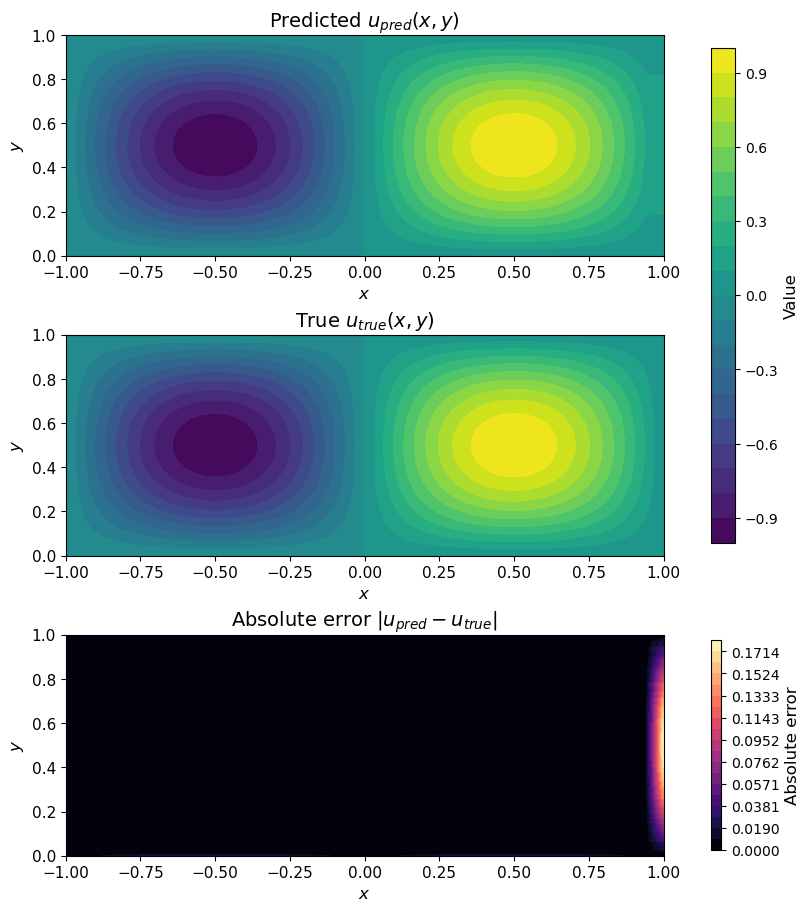

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Compute error
U_err = np.abs(U_pred - U_true)

fig, axes = plt.subplots(
    3, 1,
    figsize=(8, 9),
    constrained_layout=True
)

ax, ax1, ax2 = axes

# Shared color limits for Pred / True
levels = 20
vmin = min(U_pred.min(), U_true.min())
vmax = max(U_pred.max(), U_true.max())

# Handle constant-field edge case
if np.isclose(vmin, vmax):
    eps = 1e-12 if vmin == 0 else abs(vmin) * 1e-6
    vmin -= eps
    vmax += eps

# --------------------
# Predicted solution
# --------------------
cf_pred = ax.contourf(
    XX, YY, U_pred,
    levels=levels,
    cmap="viridis",
    vmin=vmin,
    vmax=vmax
)
ax.set_title("Predicted $u_{pred}(x,y)$", fontsize=14)
ax.set_xlabel("$x$", fontsize=12)
ax.set_ylabel("$y$", fontsize=12)
ax.tick_params(labelsize=11)

# --------------------
# True solution
# --------------------
cf_true = ax1.contourf(
    XX, YY, U_true,
    levels=levels,
    cmap="viridis",
    vmin=vmin,
    vmax=vmax
)
ax1.set_title("True $u_{true}(x,y)$", fontsize=14)
ax1.set_xlabel("$x$", fontsize=12)
ax1.set_ylabel("$y$", fontsize=12)
ax1.tick_params(labelsize=11)

# --------------------
# Error plot
# --------------------
err_levels = np.linspace(0, U_err.max(), levels)

cf_err = ax2.contourf(
    XX, YY, U_err,
    levels = err_levels,
    cmap="magma"
)
ax2.set_title(r"Absolute error $|u_{pred} - u_{true}|$", fontsize=14)
ax2.set_xlabel("$x$", fontsize=12)
ax2.set_ylabel("$y$", fontsize=12)
ax2.tick_params(labelsize=11)


# --------------------
# Colorbars
# --------------------
# Shared colorbar for Pred & True
cbar_main = fig.colorbar(cf_pred, ax=[ax, ax1], shrink=0.95)
cbar_main.set_label("Value", fontsize=12)

# Separate colorbar for Error
cbar_err = fig.colorbar(cf_err, ax=ax2, shrink=0.95)
cbar_err.set_label("Absolute error", fontsize=12)

plt.show()